In [14]:
import PIL

import pandas as pd
import matplotlib.pyplot as plt

from typing import List

from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.figure import Figure

from utils.plot import DISEASE_CMAP
from utils.plot import DISEASE_CMAP, get_legend_elements

from data.transforms import get_transform
from data.datasets import collate_fn, ReflacxDataset
from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

## [Ajustable Section 1] Define the model you want to use.

In [16]:
dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": False,
        "dataset_mode": "normal",
        "bbox_to_mask": False,
        "normalise_clinical_num": False,
        "labels_cols": DEFAULT_REFLACX_LABEL_COLS,
}

detect_eval_dataset = ReflacxDataset(
    **dataset_params_dict,
    transforms=get_transform(train=False),
)

legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

## Which trained model to load is decided here.

In [17]:
legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

In [31]:
def plot_human_annotation_consistency(
    dataset: ReflacxDataset,
    idxs: List[int],
    legend_elements: List[Line2D],
    disease_cmap=DISEASE_CMAP,
) -> Figure:

    num_radiologists = len(idxs)
    disease_color_code_map= disease_cmap["solid"]
    all_targets = [dataset.prepare_input_from_data(collate_fn([dataset[idx]]), "cpu")[-1][0] for idx in idxs]

    image_path = all_targets[0]["image_path"]

    fig, axes = plt.subplots(1, num_radiologists, figsize=(num_radiologists*8, 10), dpi=80, sharex=True)
    fig.suptitle(image_path)
    fig.legend(handles=legend_elements, loc="upper right")

    img = PIL.Image.open(image_path).convert("RGB")

    for i, (ax, target) in enumerate(zip(axes, all_targets)):
        ax.imshow(img)
        ax.set_title(f"Ground Truth - {i+1} ({len(target['boxes'].detach().cpu().numpy())})")

        gt_recs = []

        for label, bbox in zip(
            target["labels"].detach().cpu().numpy(), target["boxes"].detach().cpu().numpy()
        ):
            disease = dataset.label_idx_to_disease(label)
            c = disease_color_code_map[disease]
            gt_recs.append(
                Rectangle(
                    (bbox[0], bbox[1]),
                    bbox[2] - bbox[0],
                    bbox[3] - bbox[1],
                    fill=False,
                    color=c,
                    linewidth=2,
                )
            )
            ax.text(bbox[0], bbox[1], disease, color="black", backgroundcolor=c)

        for rec in gt_recs:
            ax.add_patch(rec)

    plt.plot()
    plt.pause(0.01)

    return fig

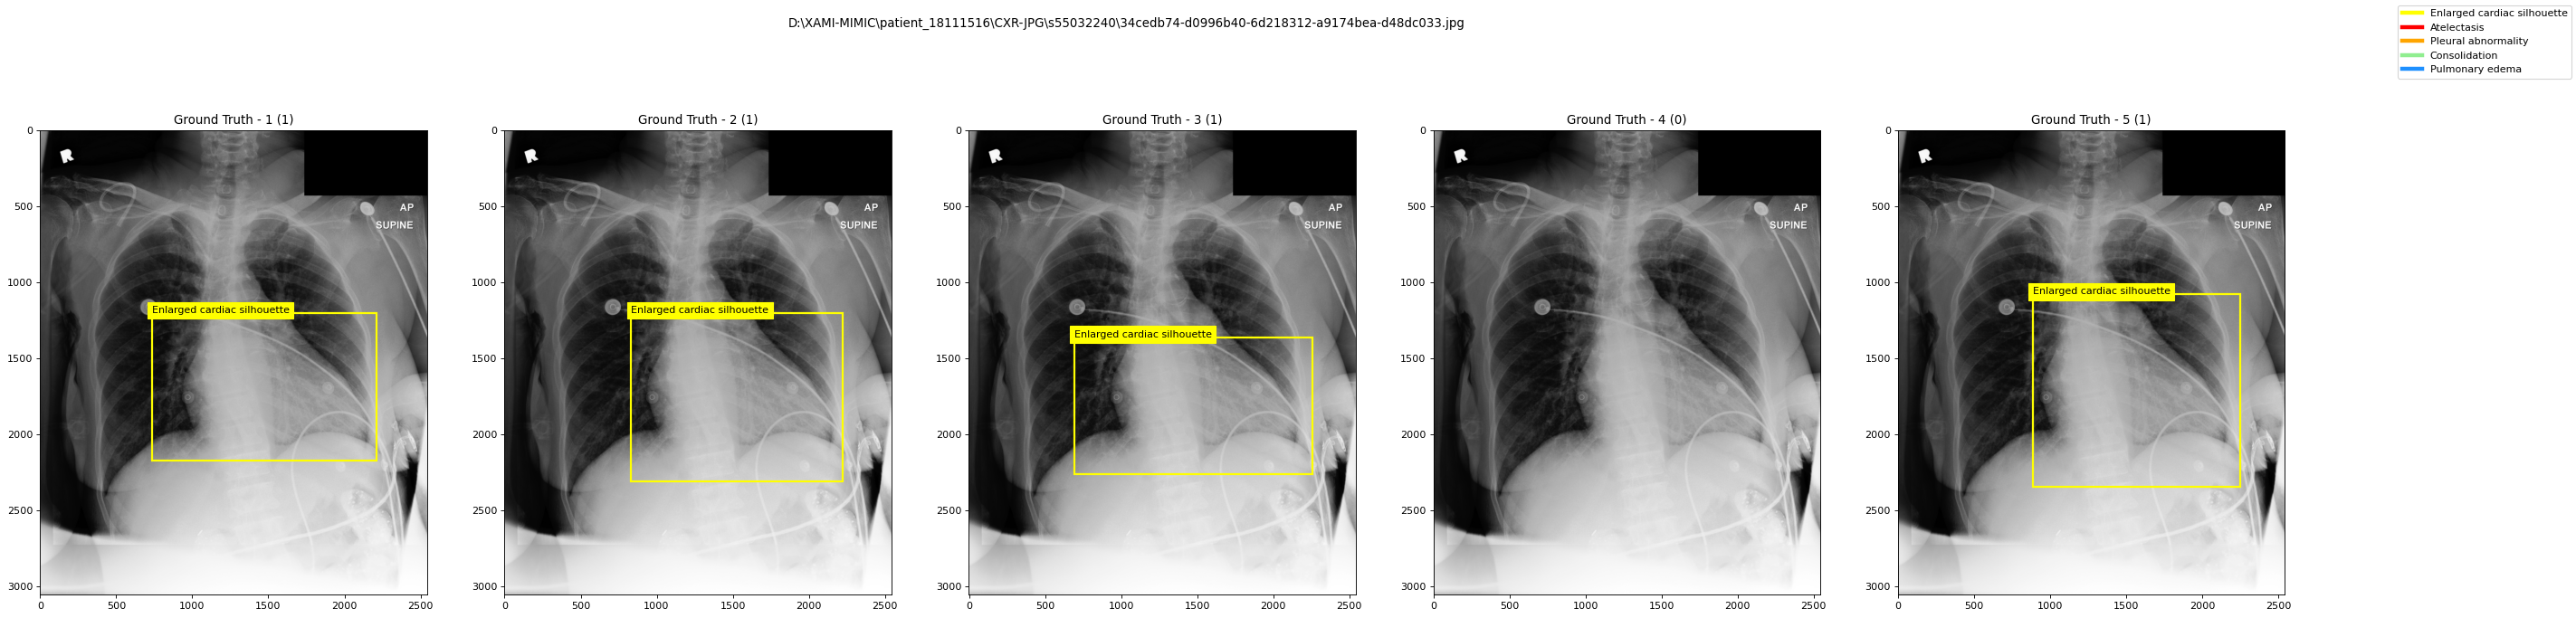

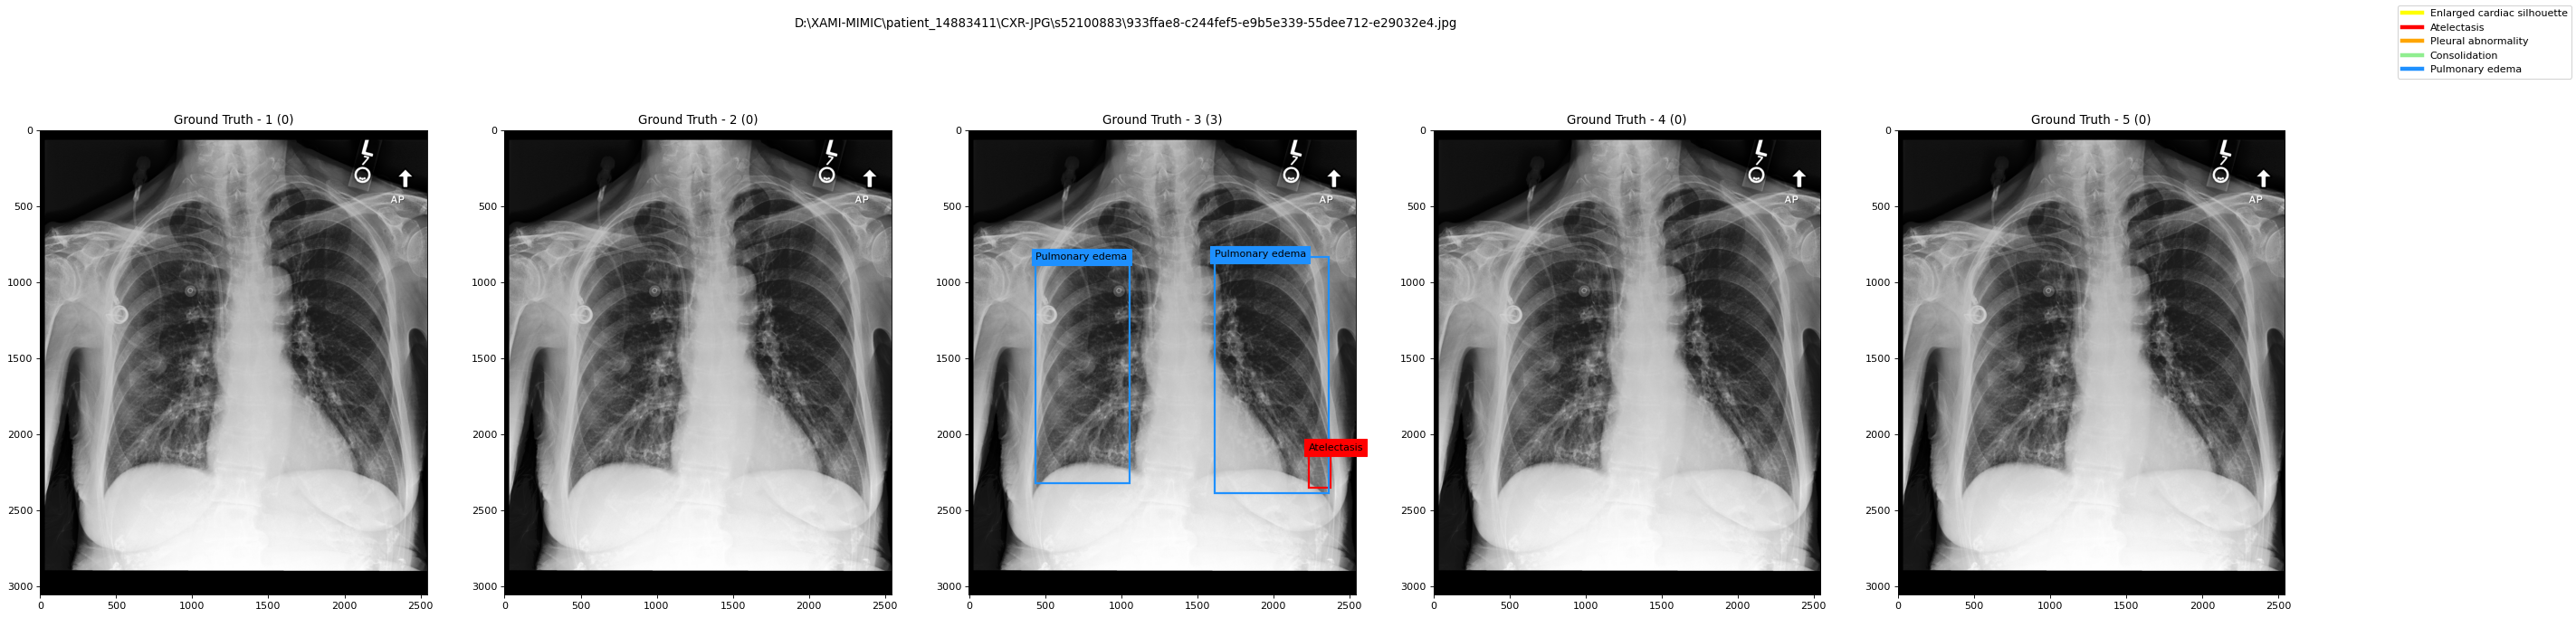

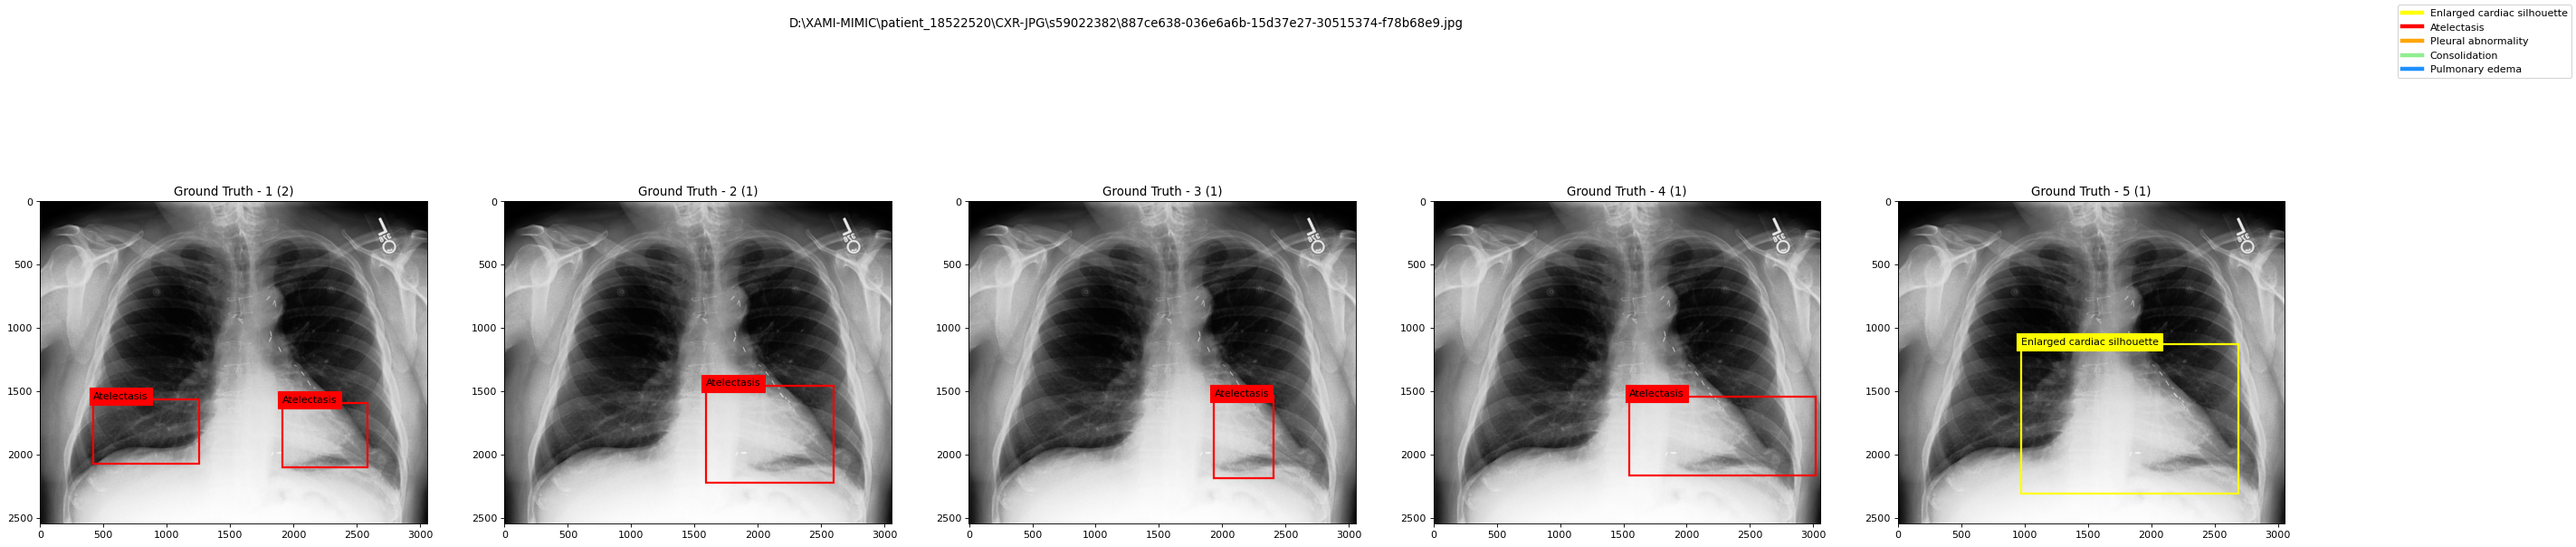

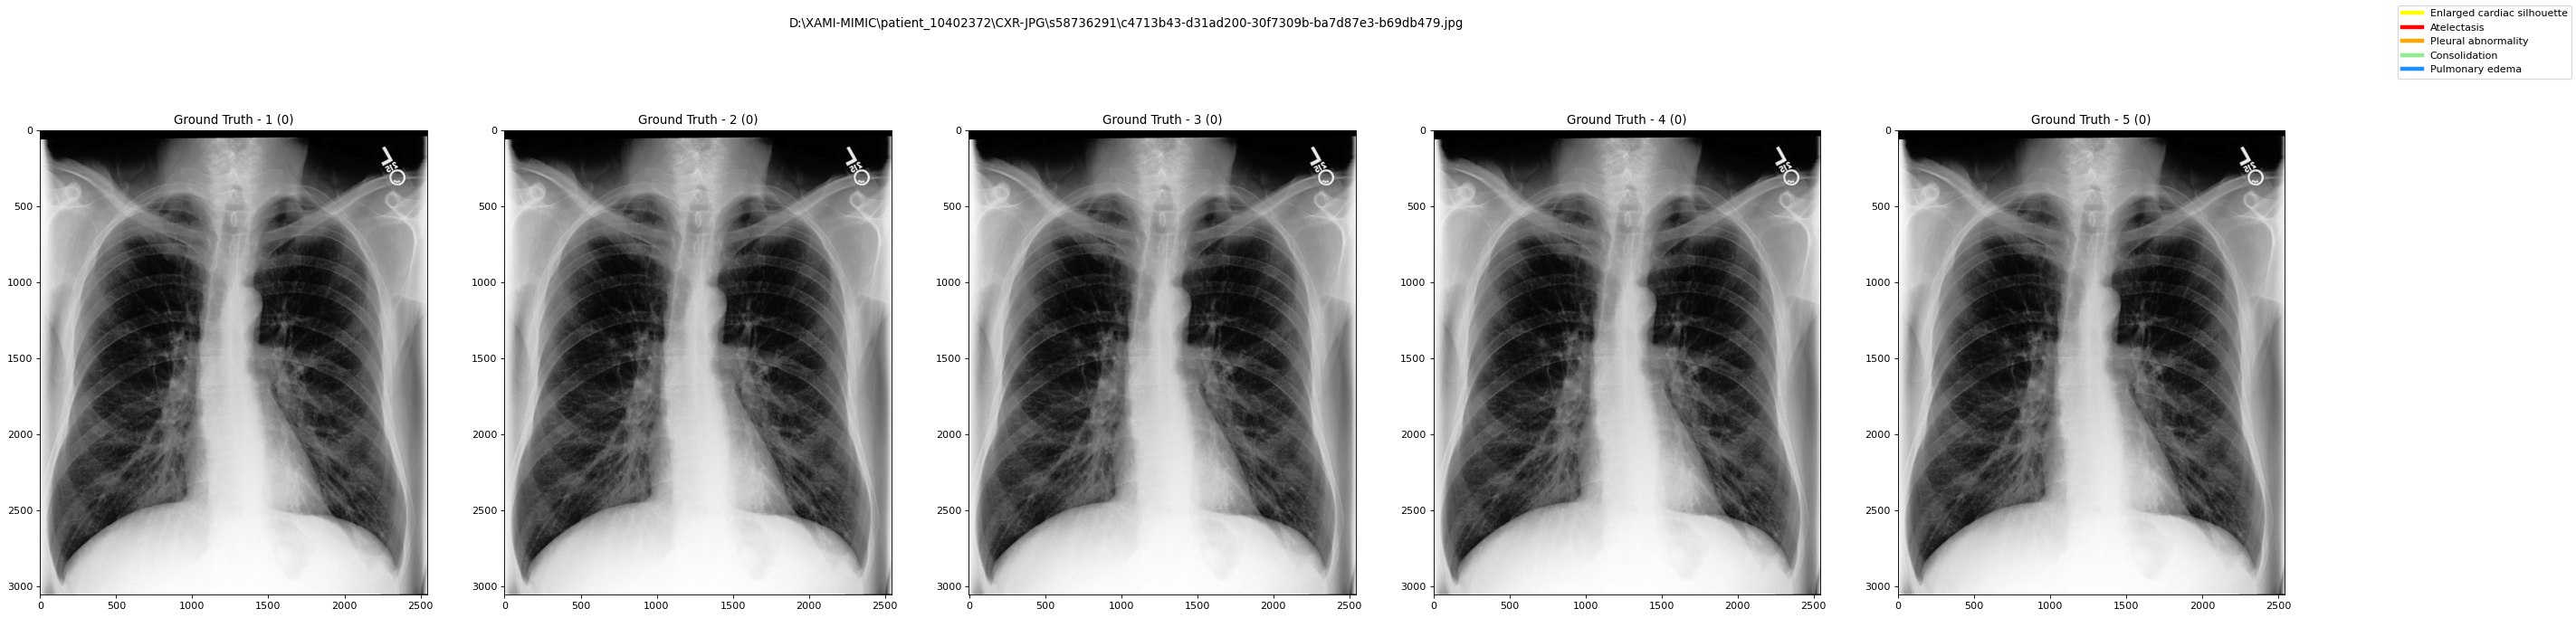

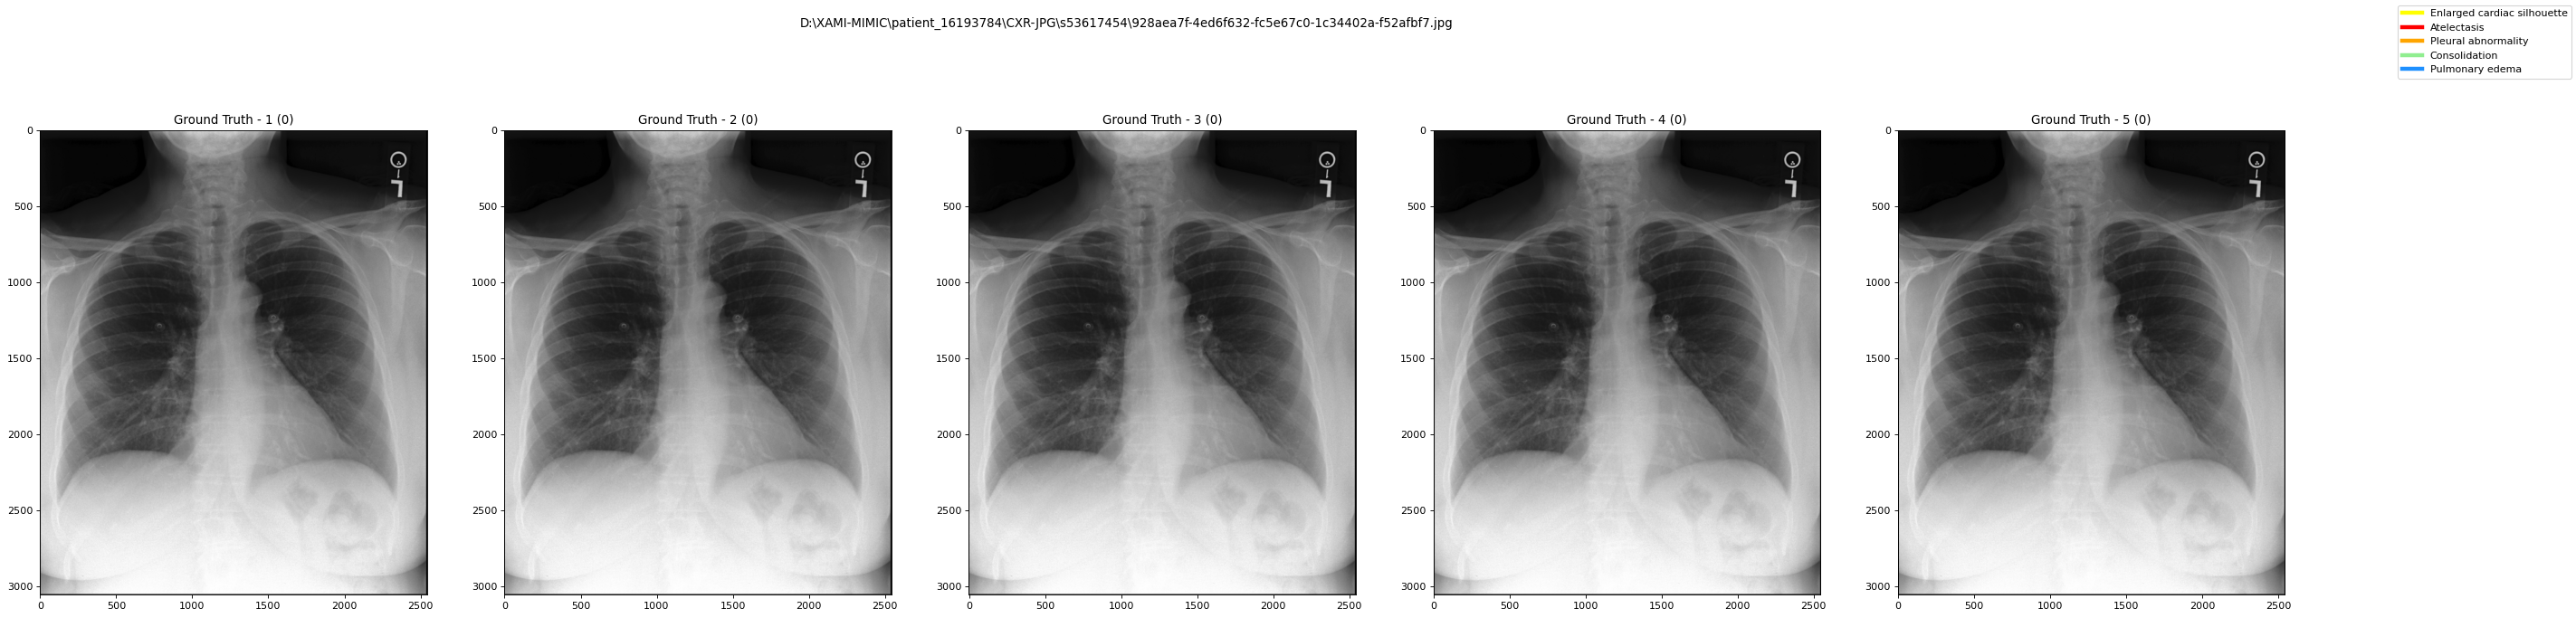

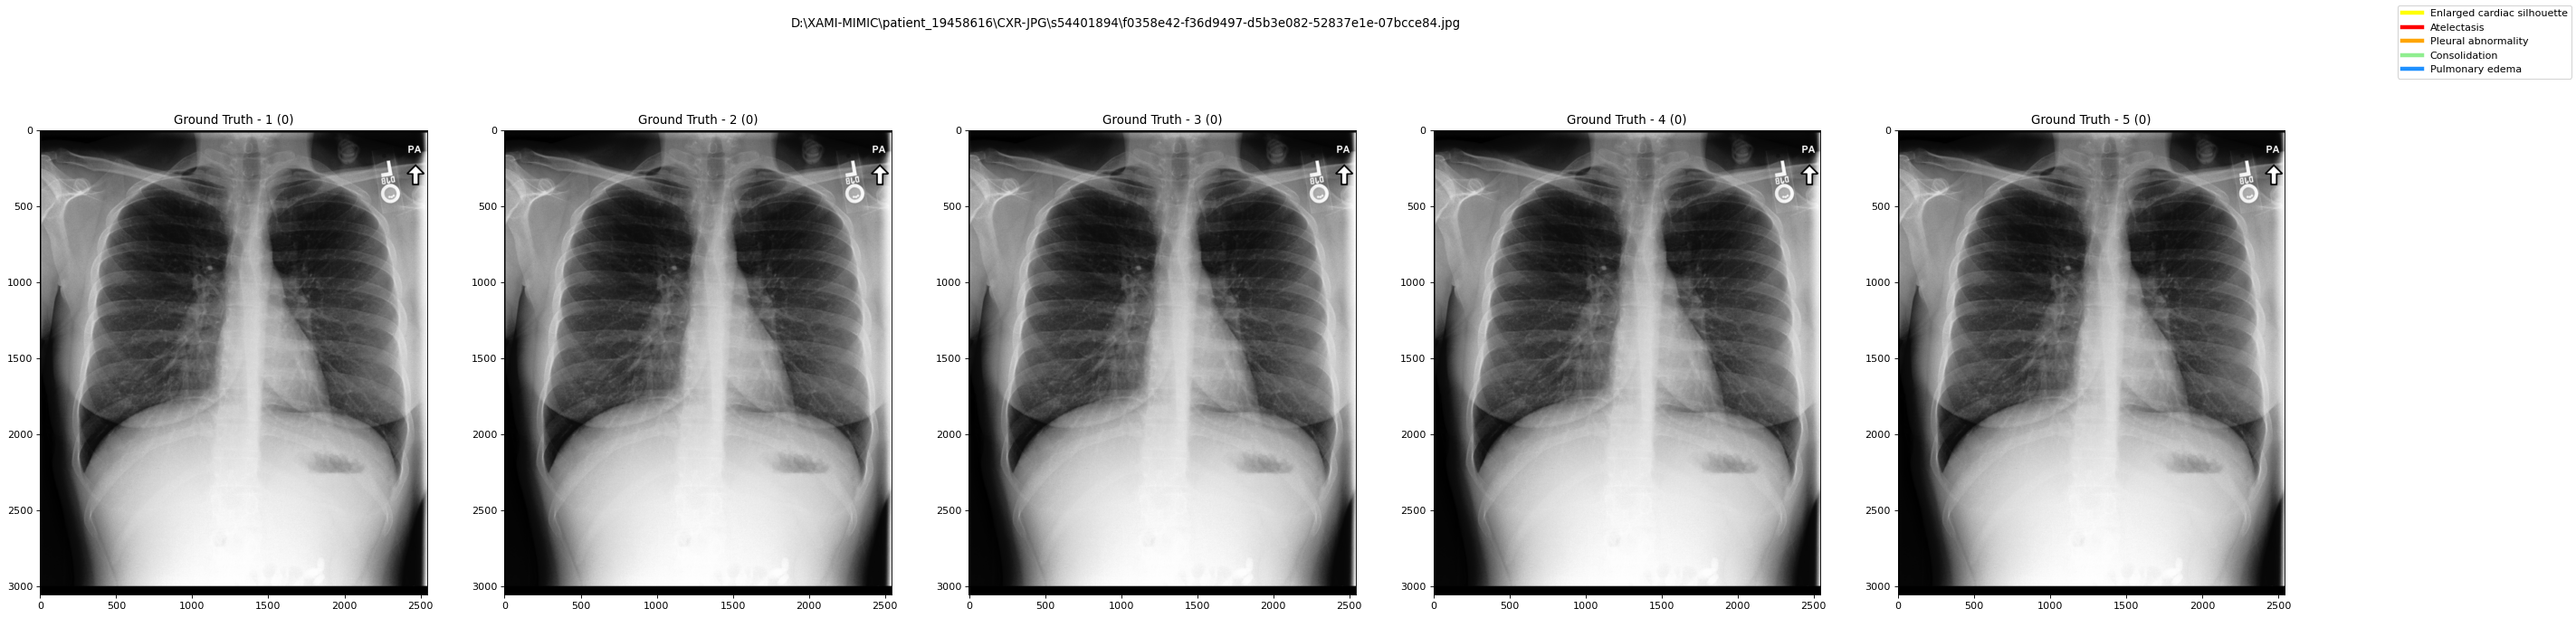

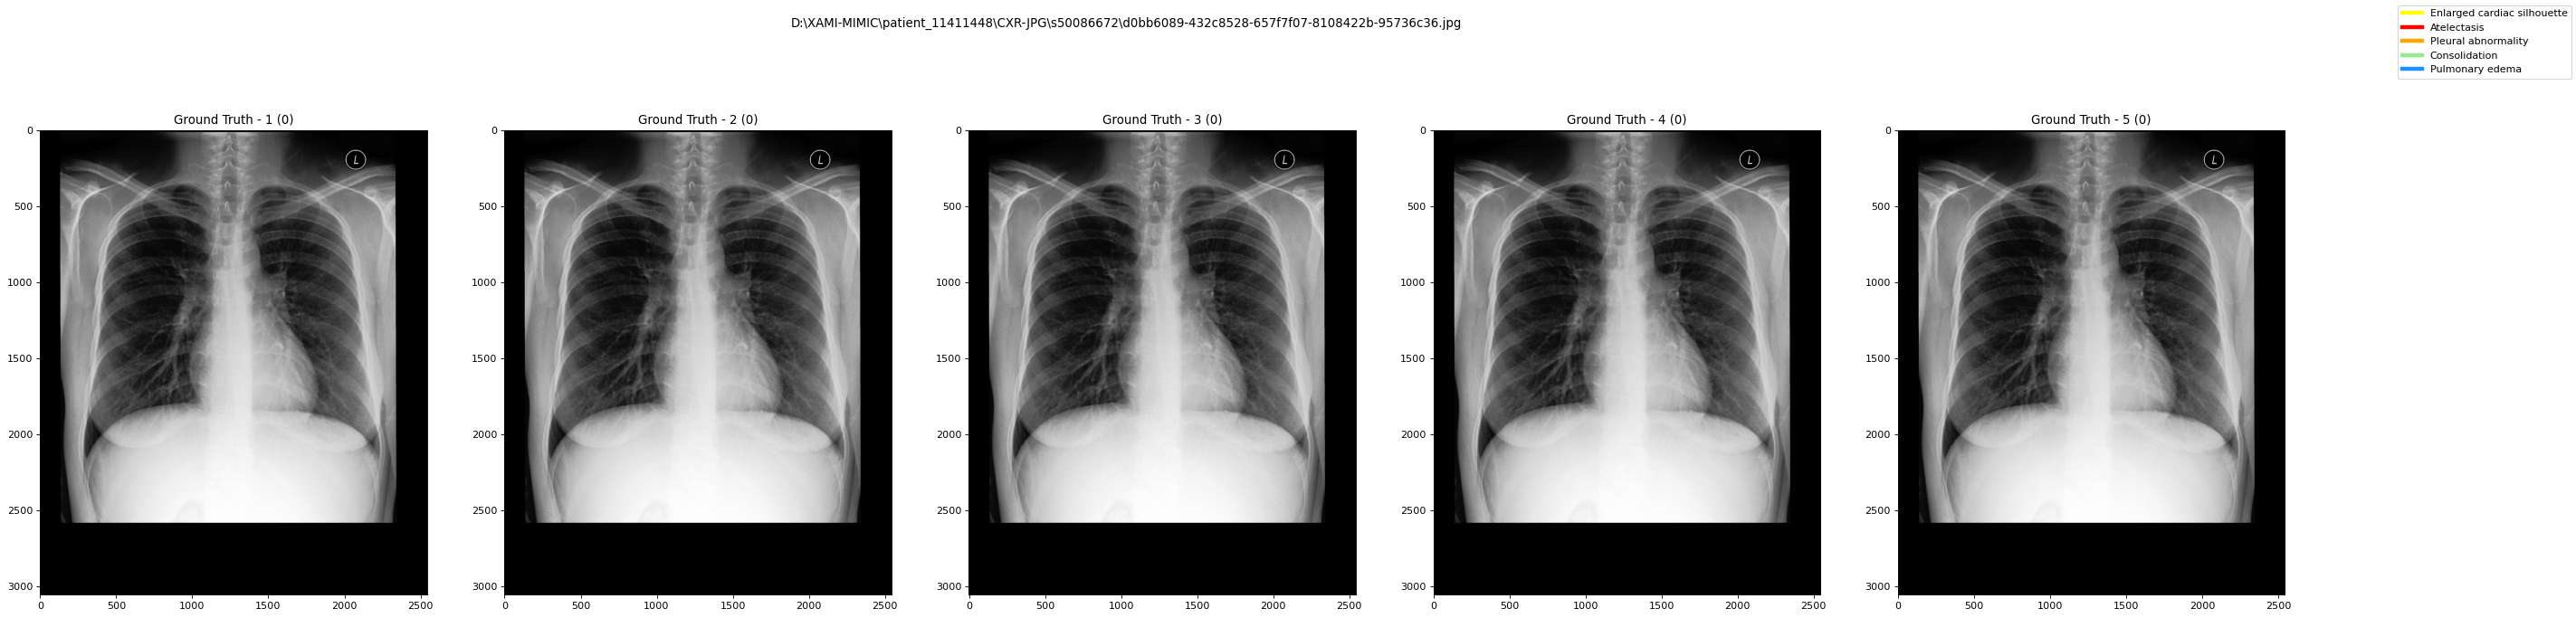

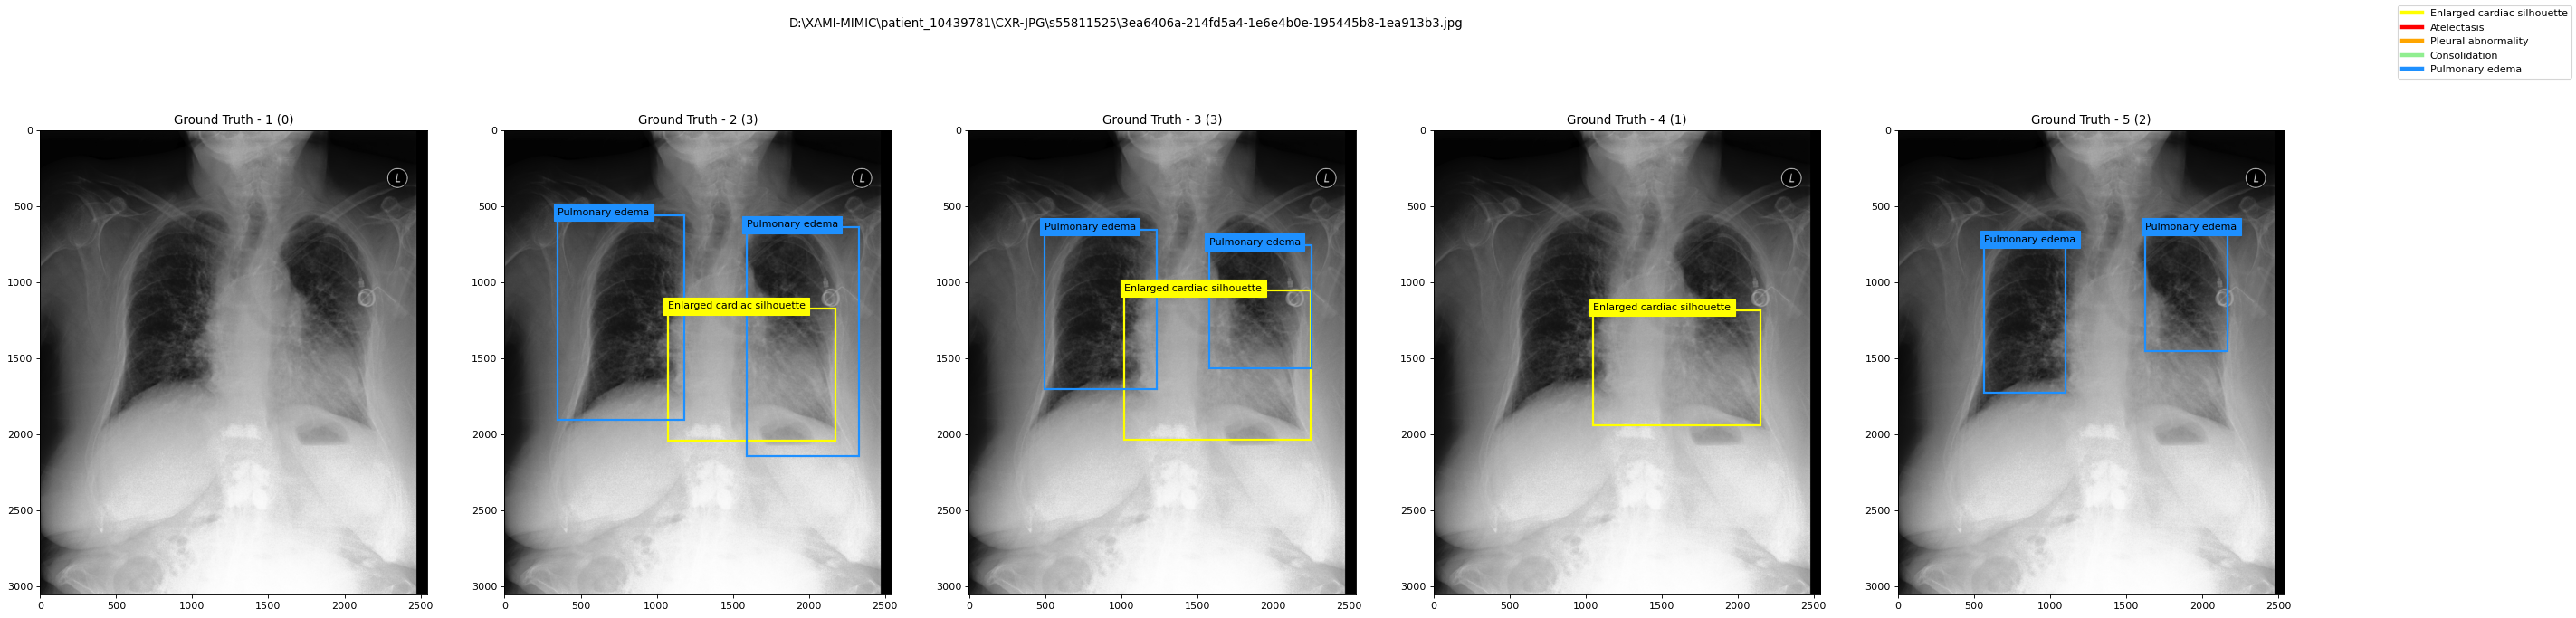

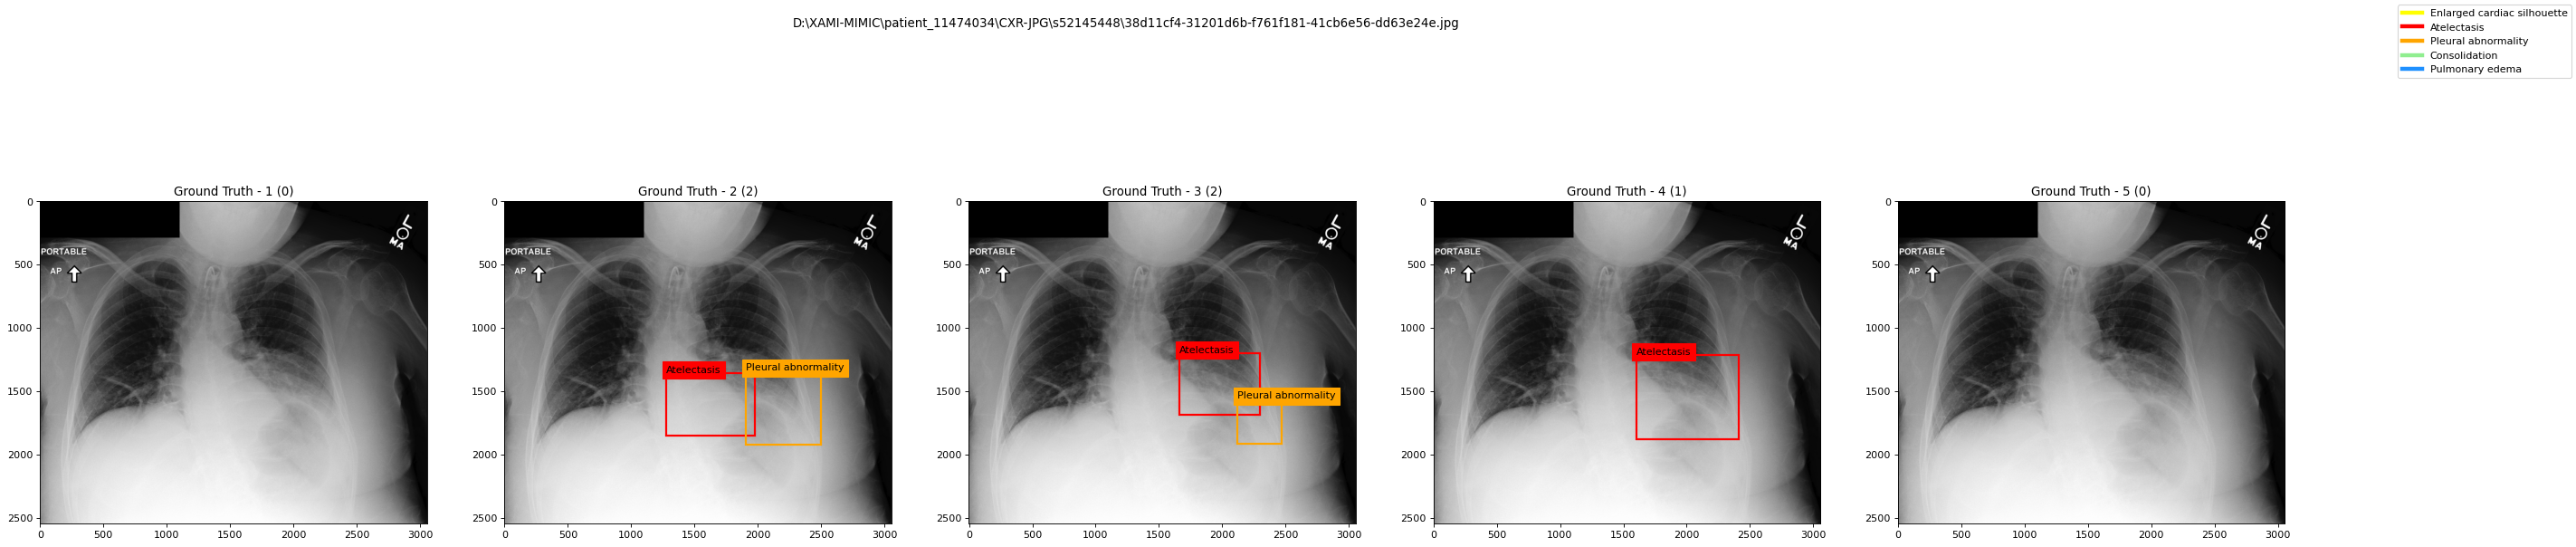

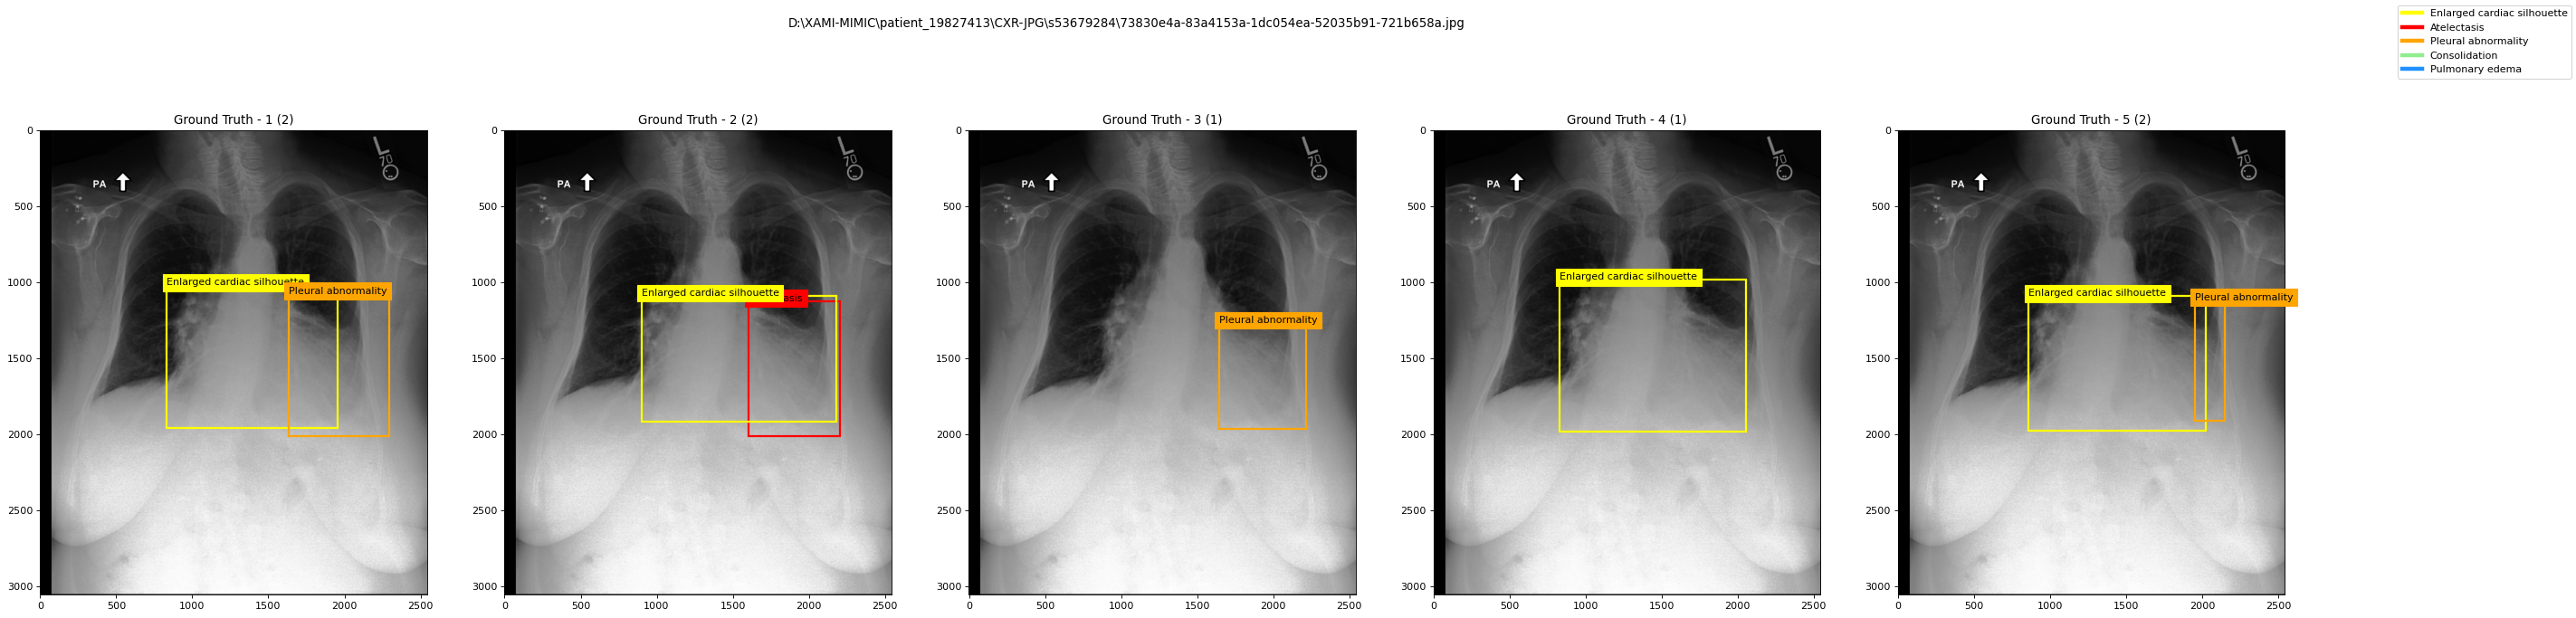

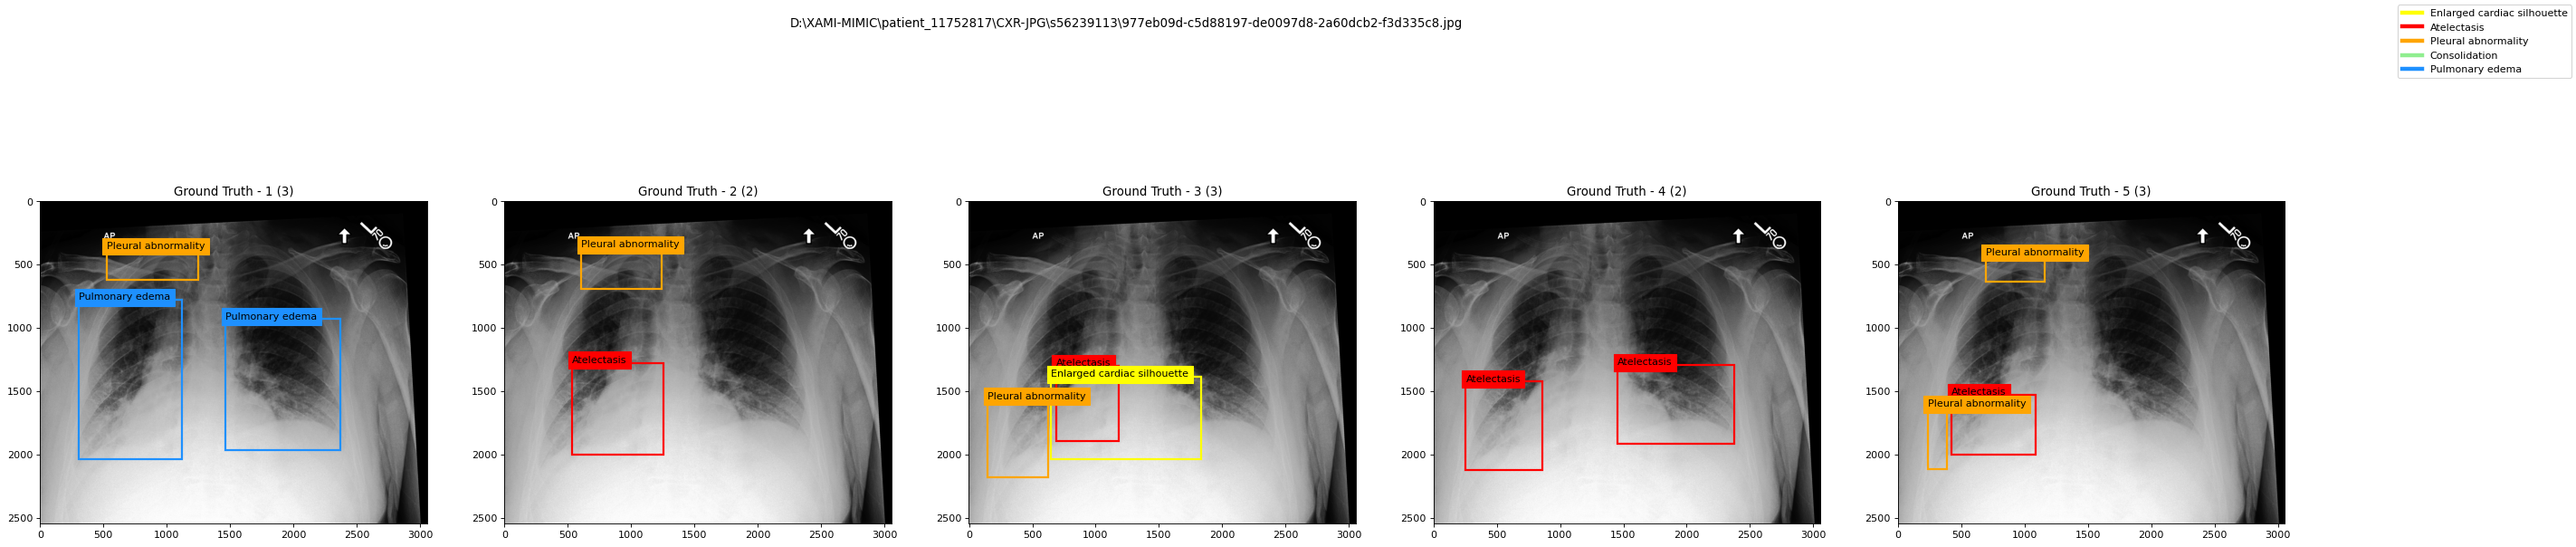

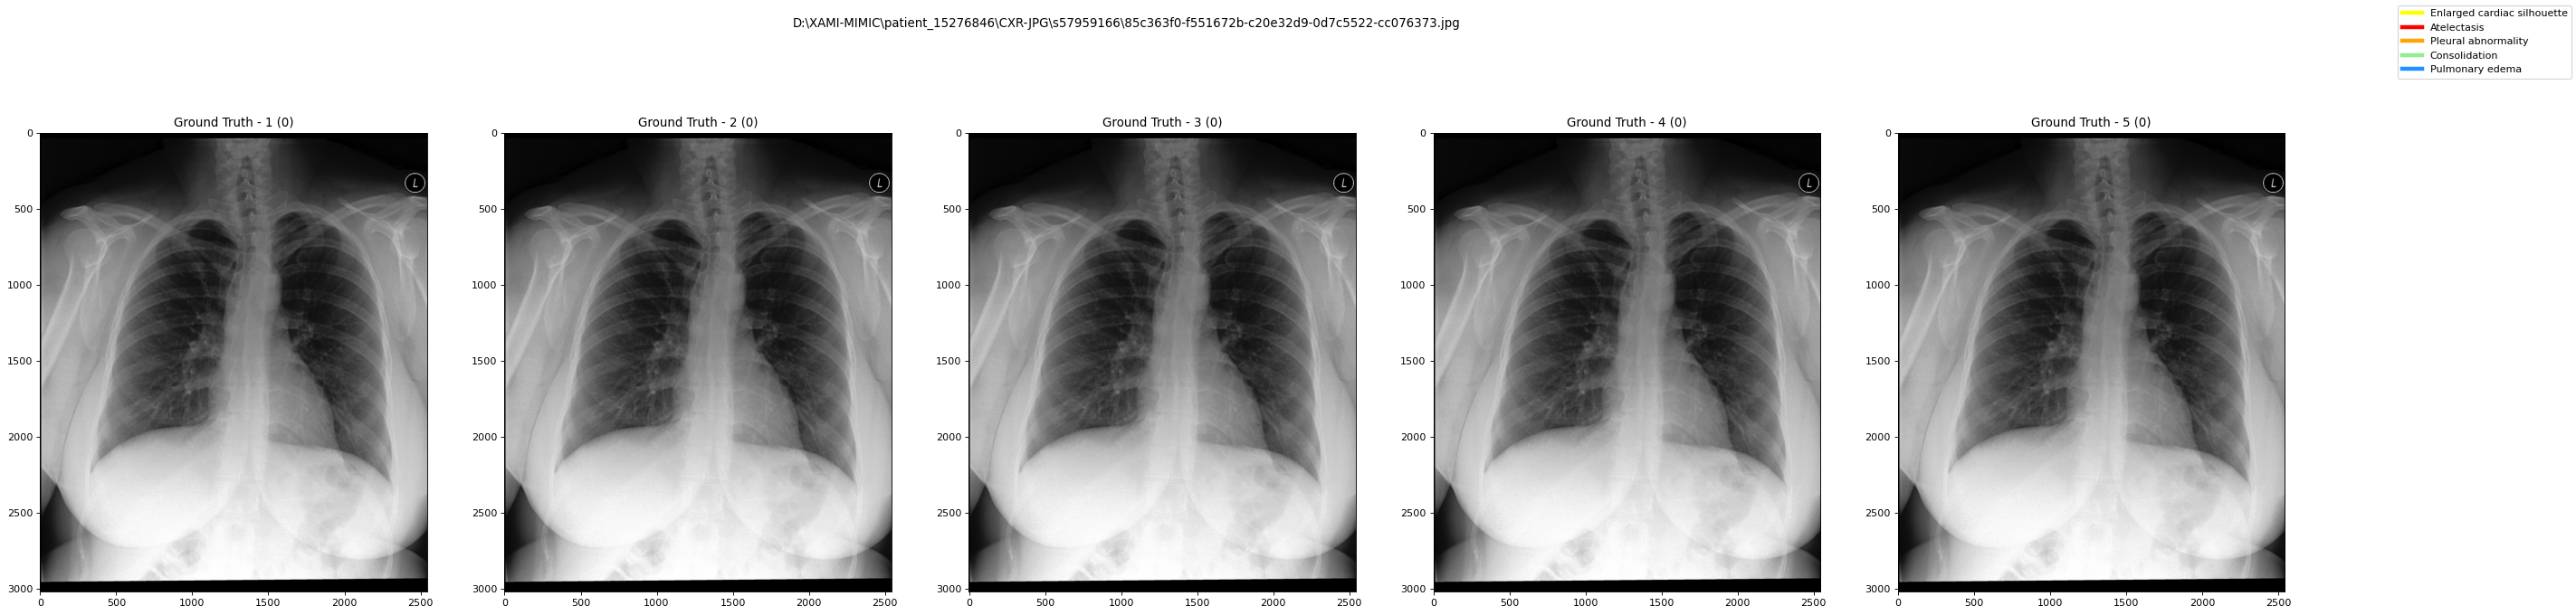

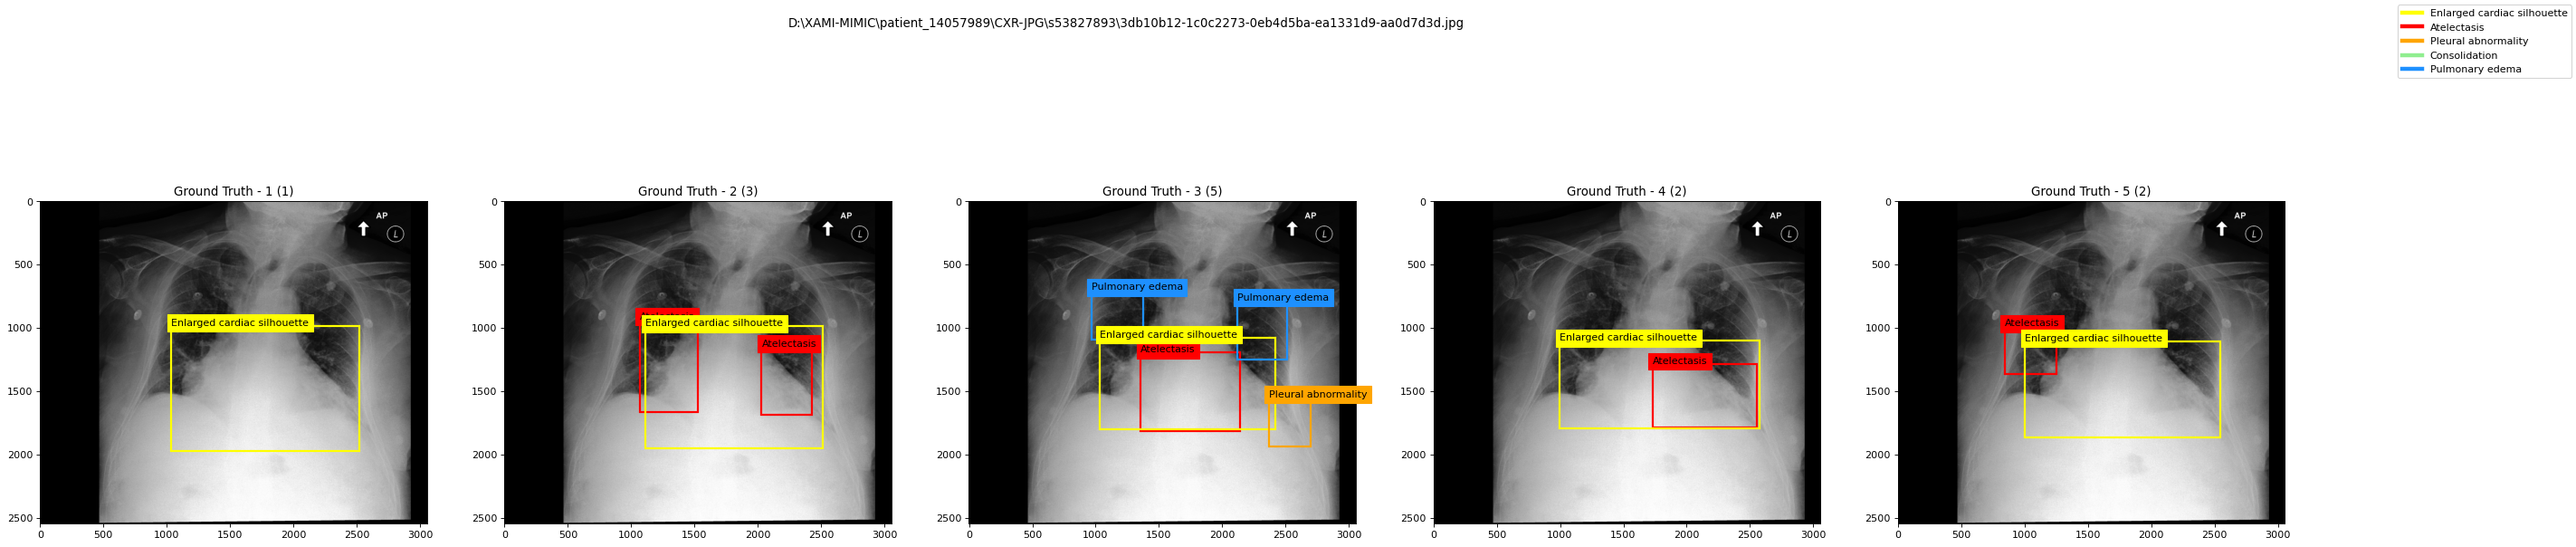

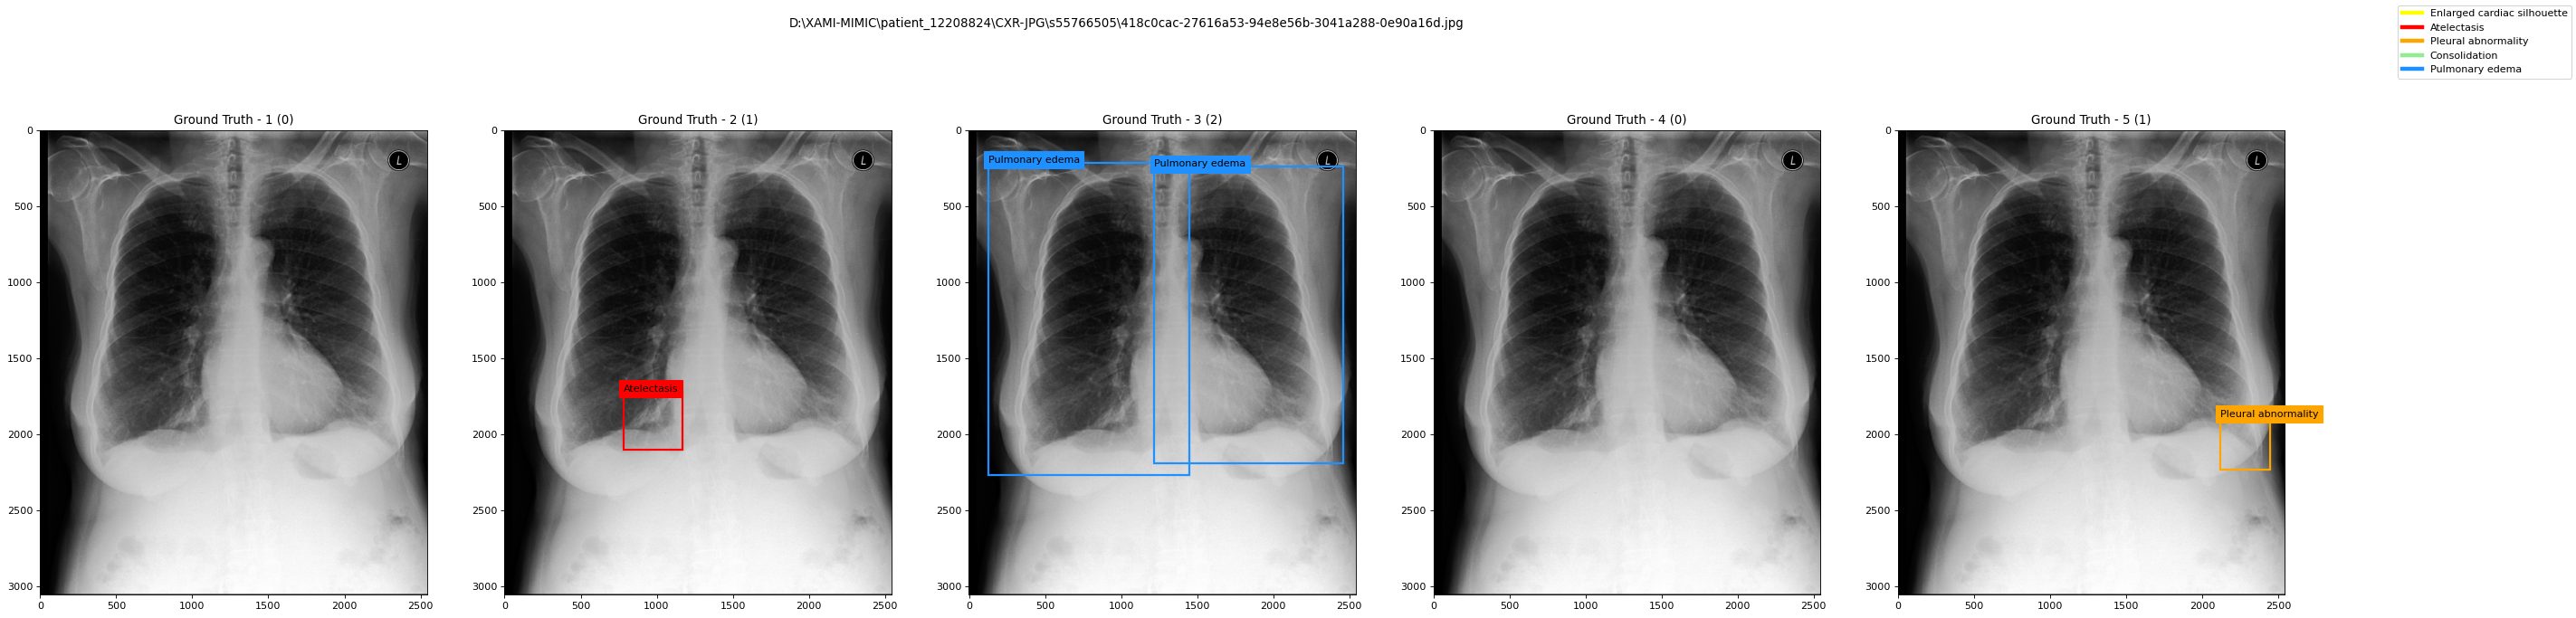

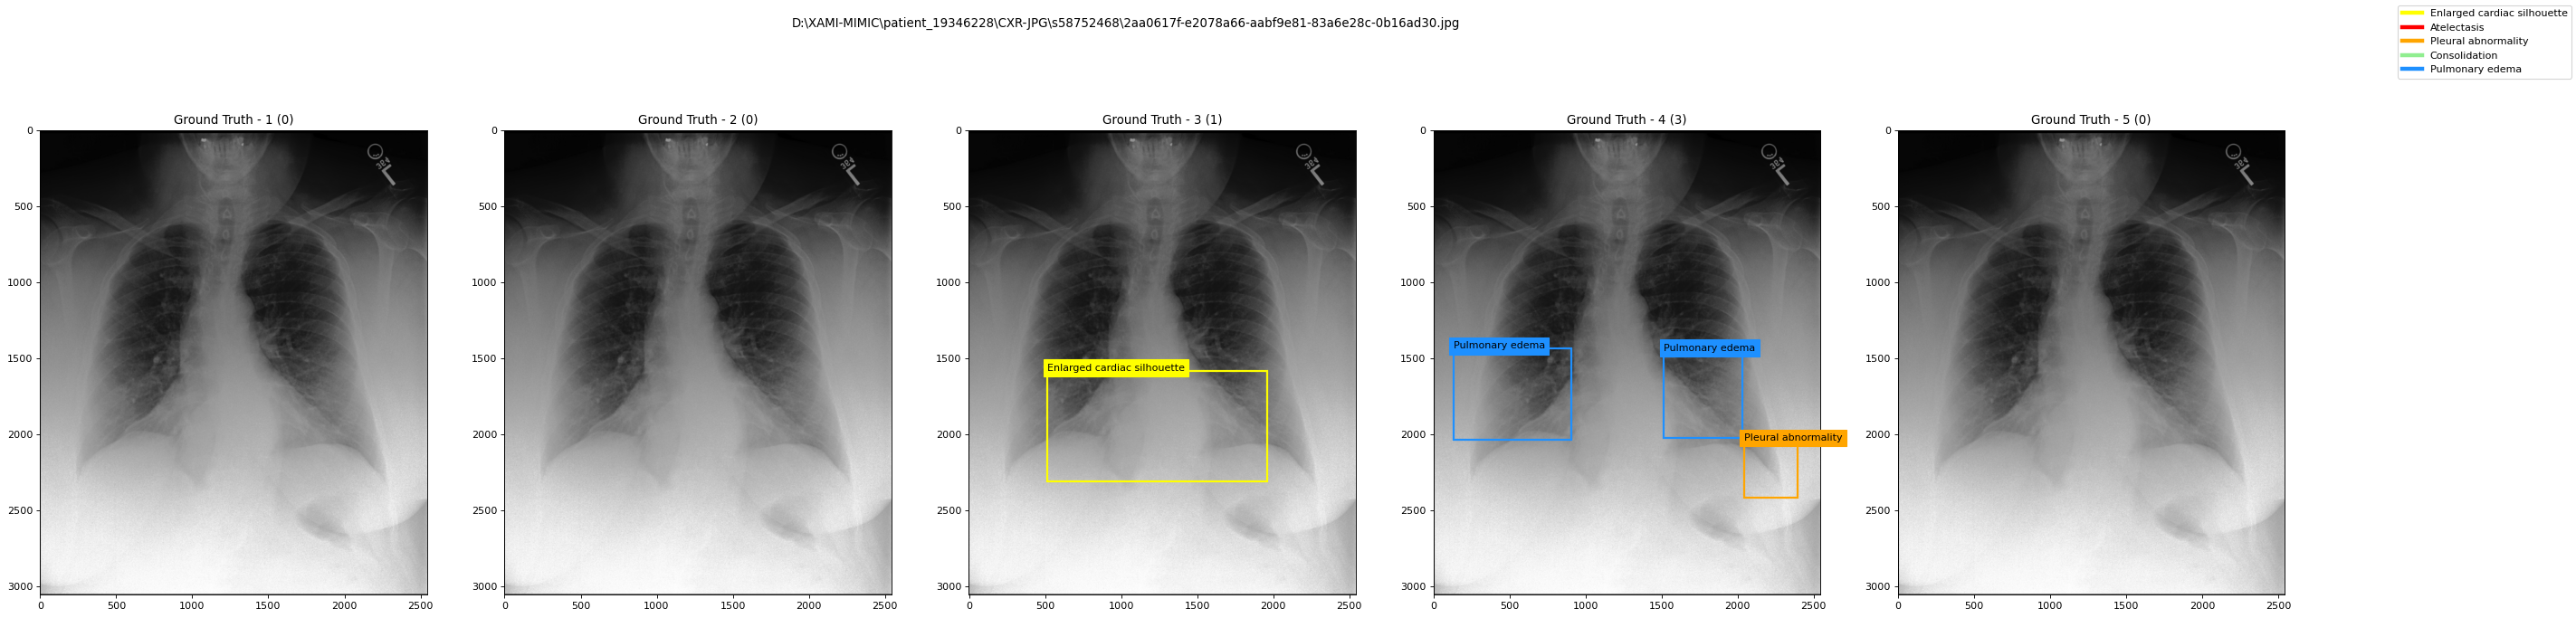

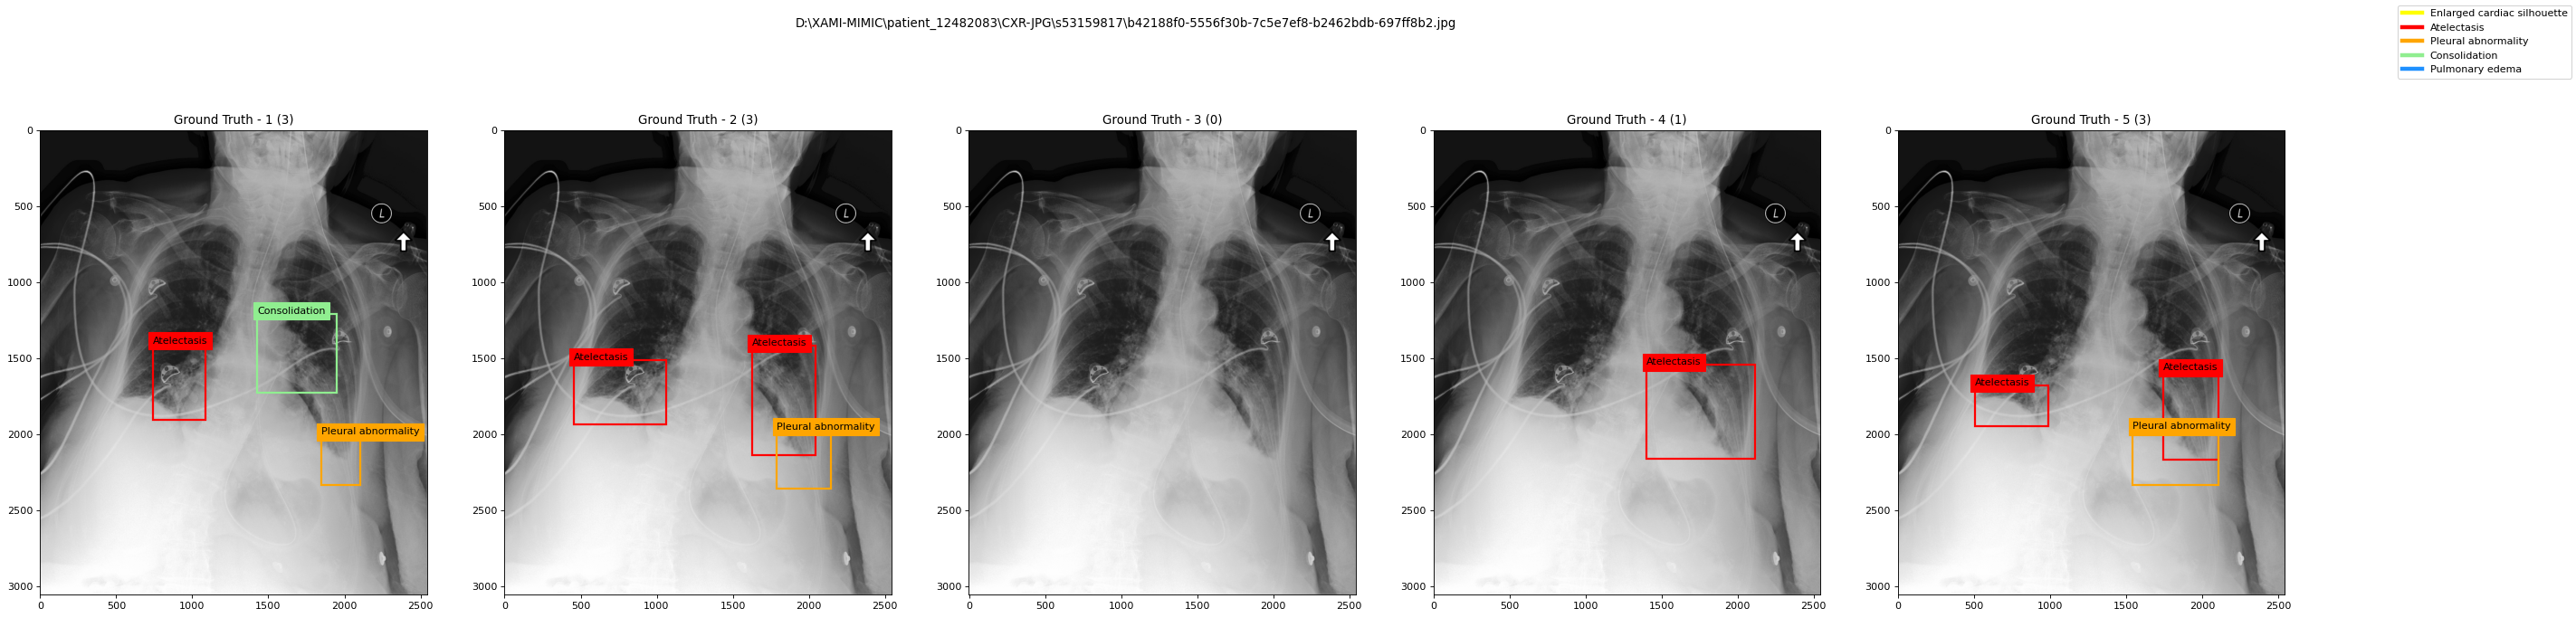

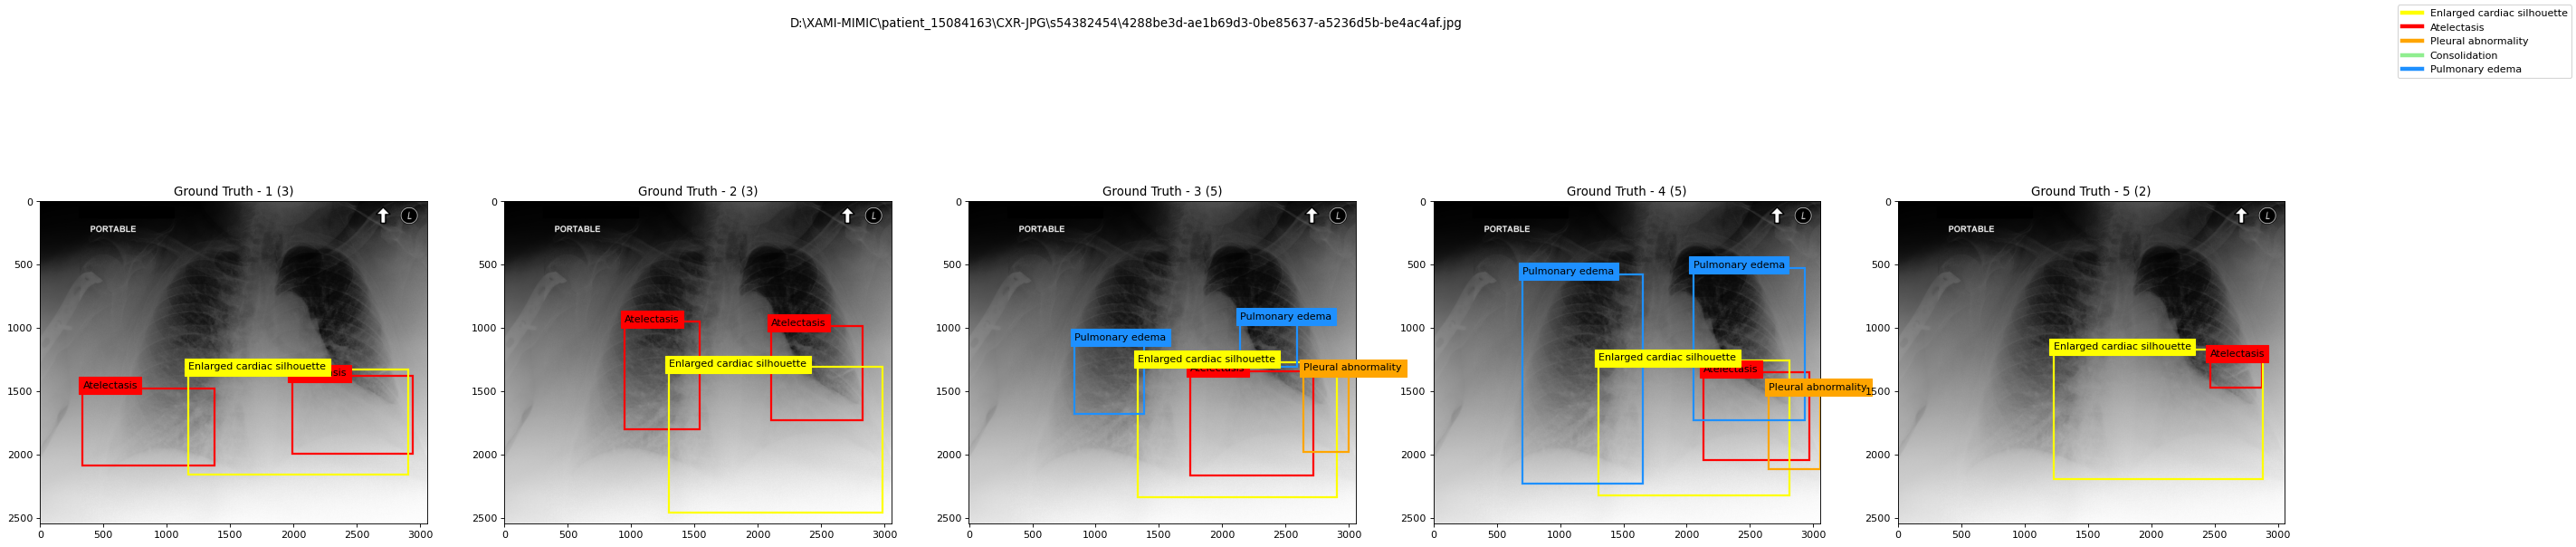

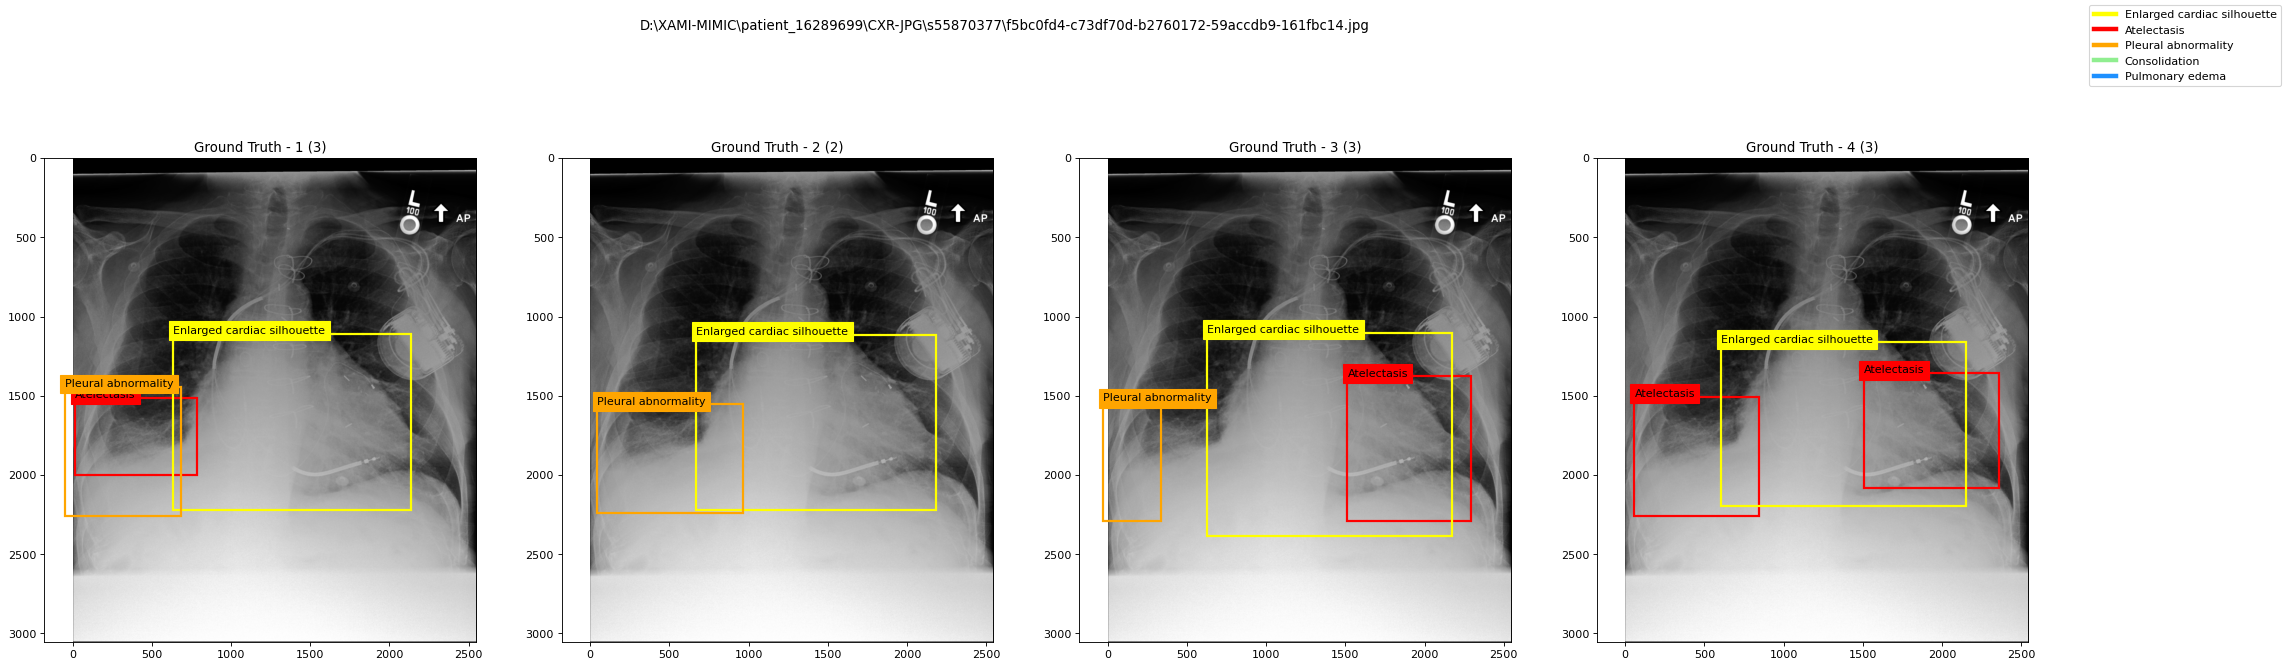

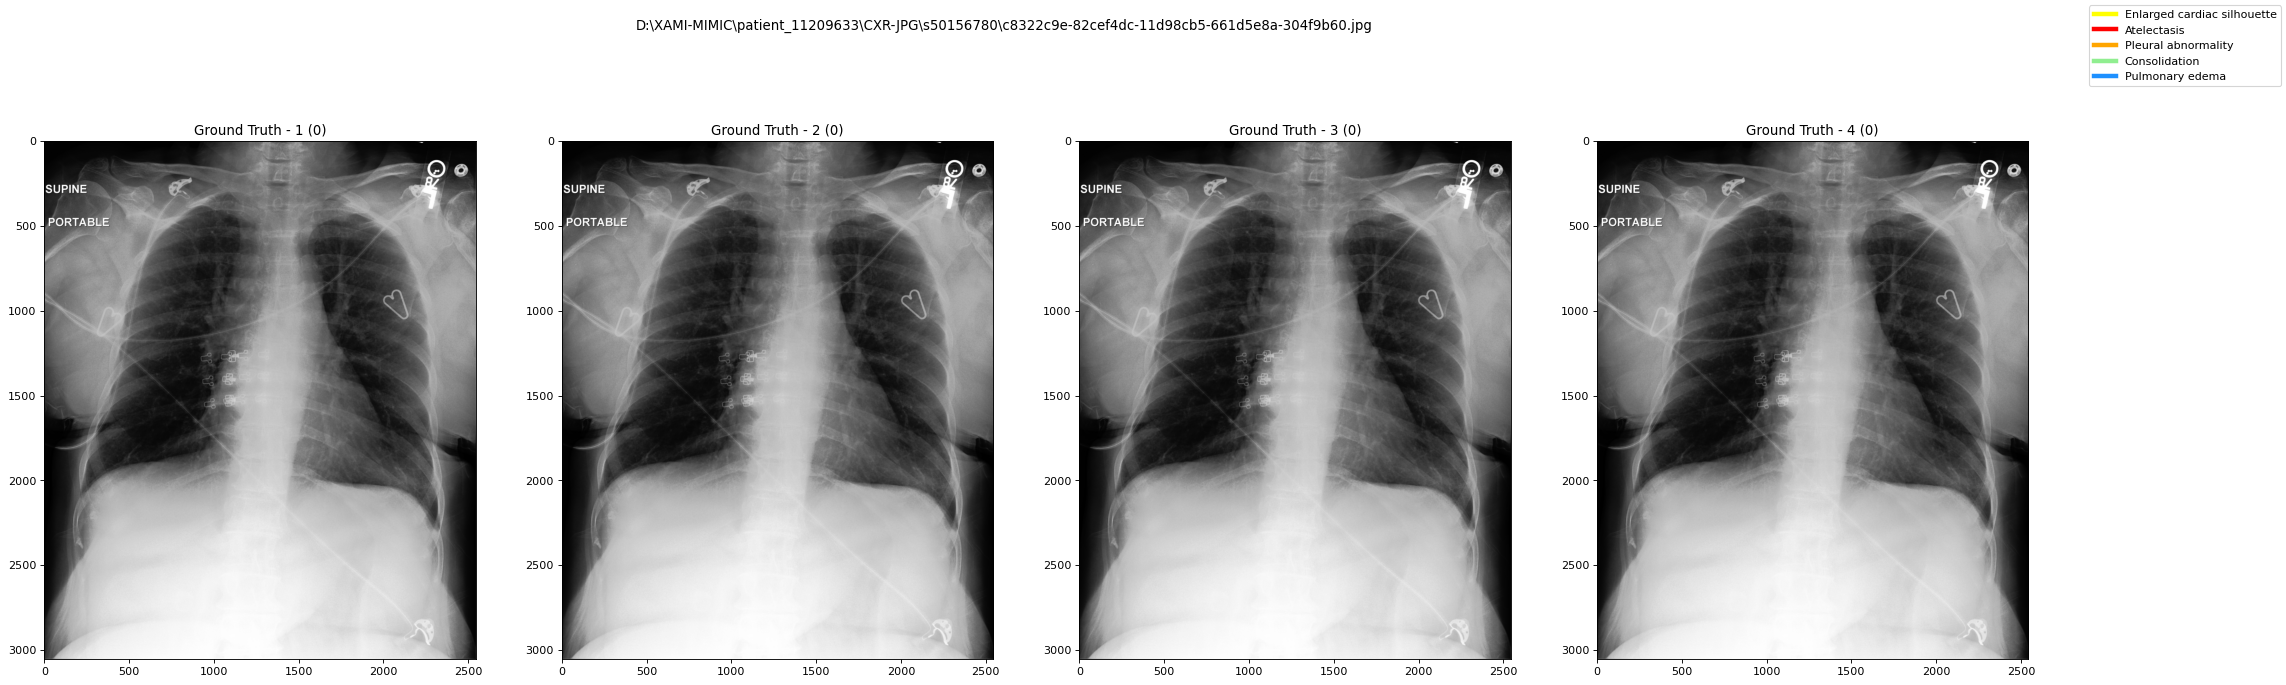

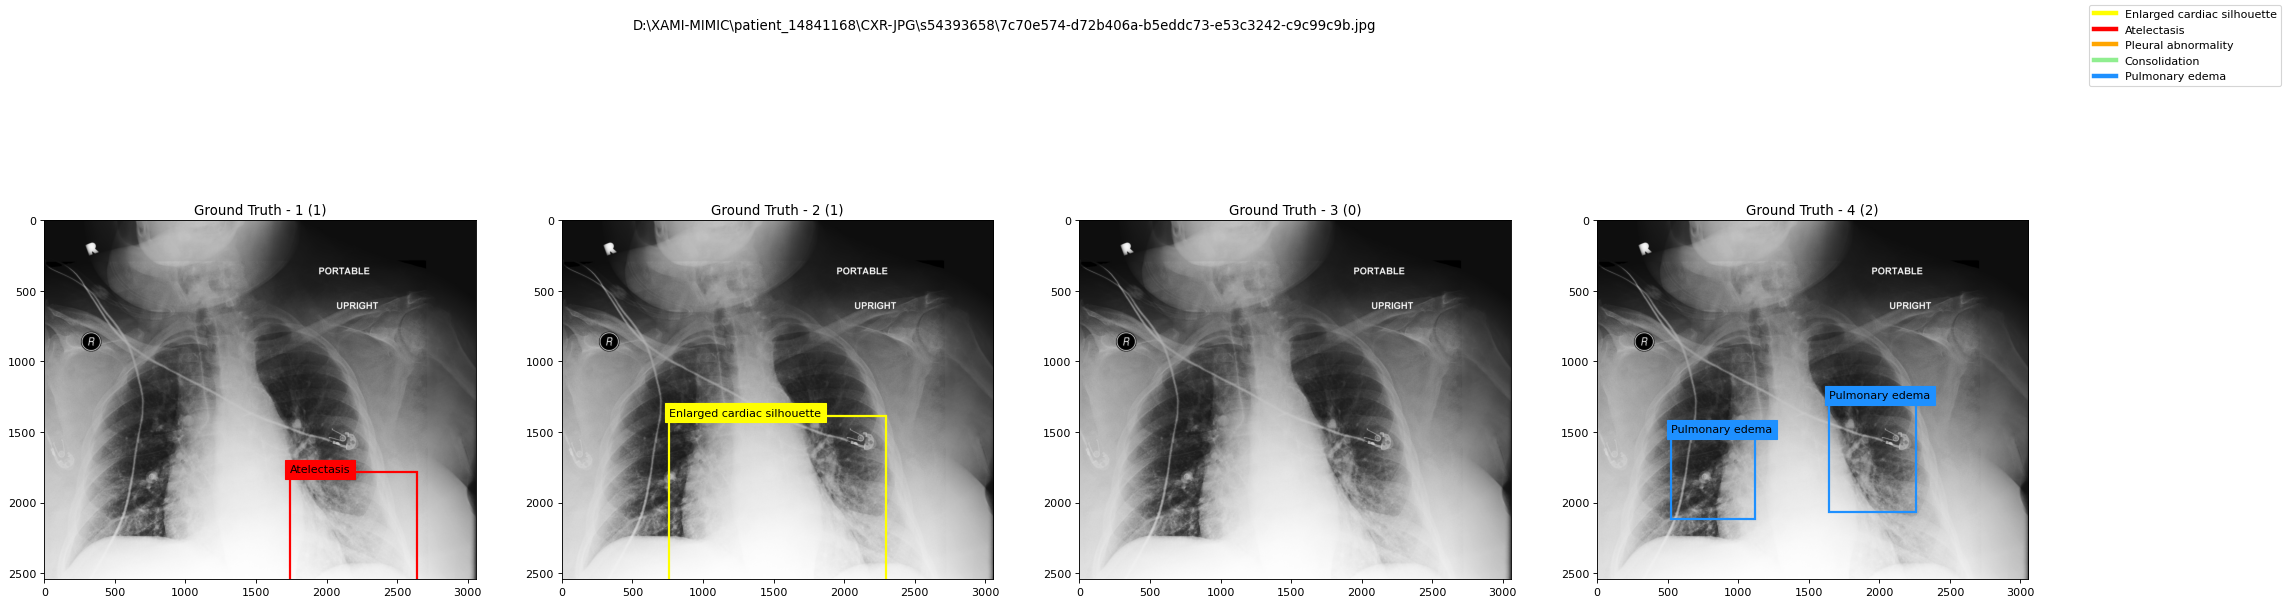

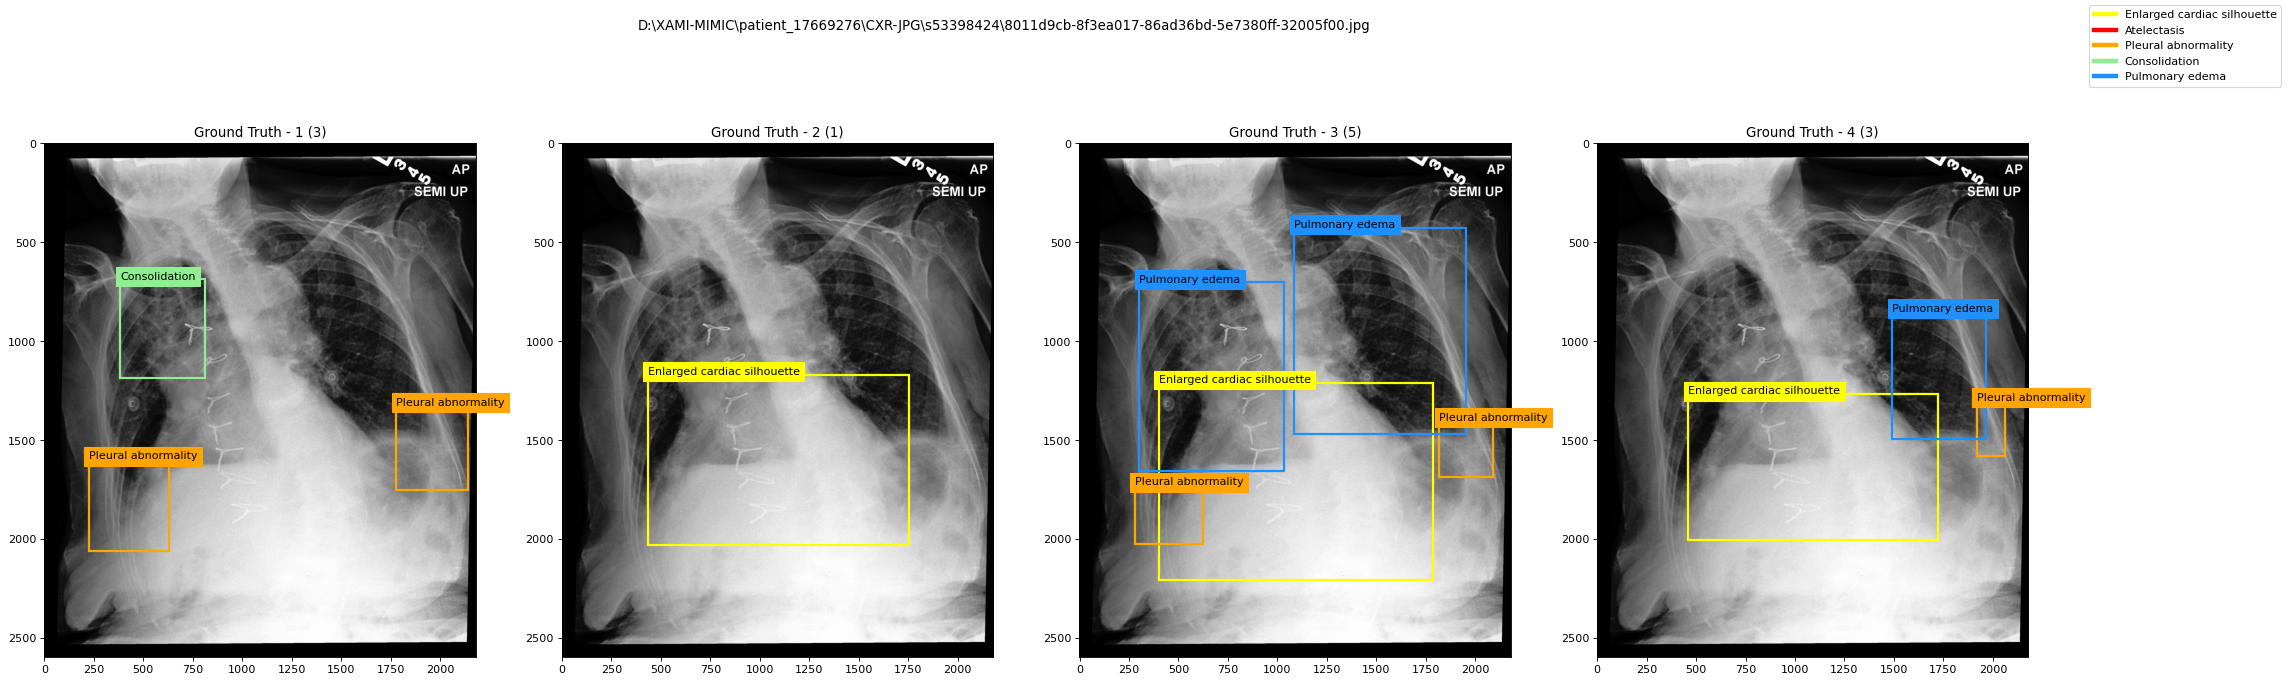

In [32]:
for d_id in [
    k
    for k, v in dict(detect_eval_dataset.df["dicom_id"].value_counts()).items()
    if v > 1
]:
    # get all the idxs for this image.
    idxs = detect_eval_dataset.get_idxs_from_dicom_id(d_id)

    plot_human_annotation_consistency(
        detect_eval_dataset, idxs, legend_elements, disease_cmap=DISEASE_CMAP,
    )
